## 1. Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier

from sklearn.multioutput import MultiOutputClassifier

In [2]:
dataset_scaled = pd.read_csv('DATASET.csv')

In [3]:
pleasant_weather = pd.read_csv('Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv')

In [4]:
print(dataset_scaled.dtypes.to_string())

DATE                             int64
MONTH                            int64
BASEL_cloud_cover              float64
BASEL_wind_speed               float64
BASEL_humidity                 float64
BASEL_pressure                 float64
BASEL_global_radiation         float64
BASEL_precipitation            float64
BASEL_snow_depth               float64
BASEL_sunshine                 float64
BASEL_temp_mean                float64
BASEL_temp_min                 float64
BASEL_temp_max                 float64
BELGRADE_cloud_cover           float64
BELGRADE_humidity              float64
BELGRADE_pressure              float64
BELGRADE_global_radiation      float64
BELGRADE_precipitation         float64
BELGRADE_sunshine              float64
BELGRADE_temp_mean             float64
BELGRADE_temp_min              float64
BELGRADE_temp_max              float64
BUDAPEST_cloud_cover           float64
BUDAPEST_humidity              float64
BUDAPEST_pressure              float64
BUDAPEST_global_radiation

In [5]:
print(pleasant_weather.dtypes.to_string())

DATE                           int64
BASEL_pleasant_weather         int64
BELGRADE_pleasant_weather      int64
BUDAPEST_pleasant_weather      int64
DEBILT_pleasant_weather        int64
DUSSELDORF_pleasant_weather    int64
HEATHROW_pleasant_weather      int64
KASSEL_pleasant_weather        int64
LJUBLJANA_pleasant_weather     int64
MAASTRICHT_pleasant_weather    int64
MADRID_pleasant_weather        int64
MUNCHENB_pleasant_weather      int64
OSLO_pleasant_weather          int64
SONNBLICK_pleasant_weather     int64
STOCKHOLM_pleasant_weather     int64
VALENTIA_pleasant_weather      int64


###  Curate temperature variables & exclude Gdasnk, Roma, Tour

In [6]:
### List comprehension to filter columns
columns_to_keep = [
    col for col in dataset_scaled.columns
    if 'temp_' in col
    and not any(city in col for city in ['ROMA', 'TOURS', 'GDANSK'])
]

# Create the new DataFrame
df_temp = dataset_scaled[columns_to_keep]


In [7]:
df_temp.shape

(22950, 45)

In [8]:
pleasant_weather.shape

(22950, 16)

## 2. Prepare Training Dataset

In [9]:
### Create an 'X' matrix; drop unneeded columns
X = df_temp
y = pleasant_weather.drop(['DATE'], axis=1)

In [10]:
### Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [11]:
#viewing shape of training and test sets
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(17212, 45)
(5738, 45)
(17212, 15)
(5738, 15)


In [12]:
X_train.columns

Index(['BASEL_temp_mean', 'BASEL_temp_min', 'BASEL_temp_max',
       'BELGRADE_temp_mean', 'BELGRADE_temp_min', 'BELGRADE_temp_max',
       'BUDAPEST_temp_mean', 'BUDAPEST_temp_min', 'BUDAPEST_temp_max',
       'DEBILT_temp_mean', 'DEBILT_temp_min', 'DEBILT_temp_max',
       'DUSSELDORF_temp_mean', 'DUSSELDORF_temp_min', 'DUSSELDORF_temp_max',
       'HEATHROW_temp_mean', 'HEATHROW_temp_min', 'HEATHROW_temp_max',
       'KASSEL_temp_mean', 'KASSEL_temp_min', 'KASSEL_temp_max',
       'LJUBLJANA_temp_mean', 'LJUBLJANA_temp_min', 'LJUBLJANA_temp_max',
       'MAASTRICHT_temp_mean', 'MAASTRICHT_temp_min', 'MAASTRICHT_temp_max',
       'MADRID_temp_mean', 'MADRID_temp_min', 'MADRID_temp_max',
       'MUNCHENB_temp_mean', 'MUNCHENB_temp_min', 'MUNCHENB_temp_max',
       'OSLO_temp_mean', 'OSLO_temp_min', 'OSLO_temp_max',
       'SONNBLICK_temp_mean', 'SONNBLICK_temp_min', 'SONNBLICK_temp_max',
       'STOCKHOLM_temp_mean', 'STOCKHOLM_temp_min', 'STOCKHOLM_temp_max',
       'VALENTIA_temp_me

## 3. ARTIFICIAL NEURAL NETWORK

### Unscaled Data

In [13]:
dataset_unscaled = pd.read_csv('Dataset-weather-prediction-dataset-processed.csv')

In [14]:
dataset_unscaled.shape

(22950, 170)

In [15]:
### List comprehension to filter columns
columns_to_keep = [
    col for col in dataset_unscaled.columns
    if 'temp_' in col
    and not any(city in col for city in ['ROMA', 'TOURS', 'GDANSK'])
]

# Create the new DataFrame
df_temp_2 = dataset_unscaled[columns_to_keep]


In [16]:
X1 = df_temp_2

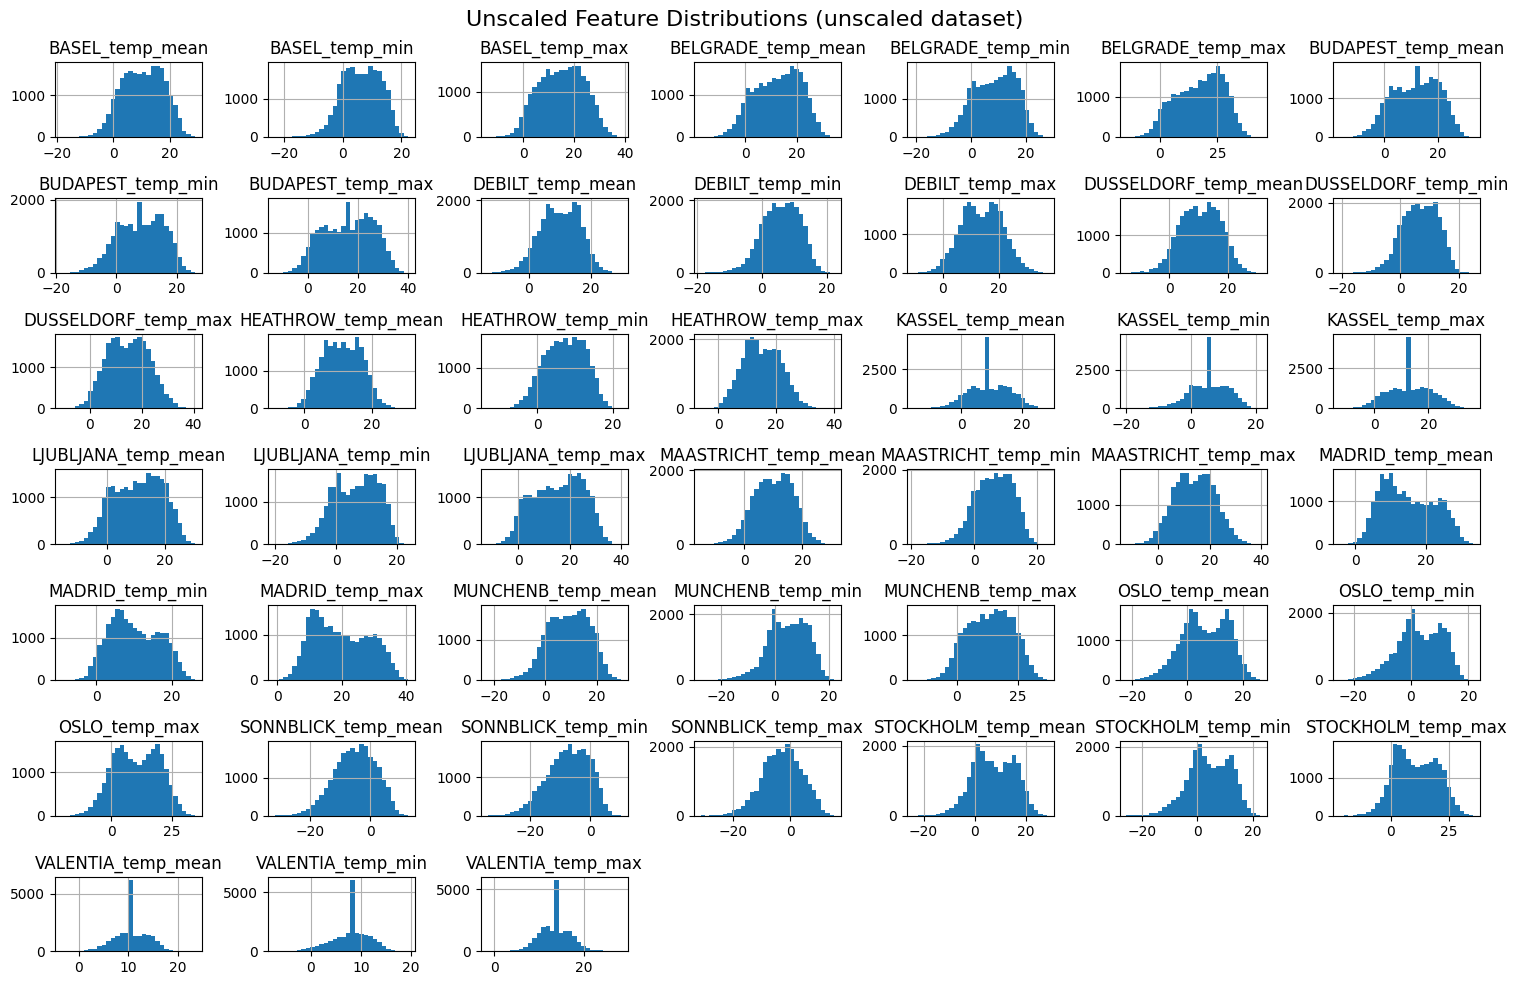

In [17]:
X1.hist(figsize=(15, 10), bins=30)
plt.suptitle("Unscaled Feature Distributions (unscaled dataset)", fontsize=16)
plt.tight_layout()
plt.show()


## Observations

Scaling is strongly recommended here. The unscaled distributions in your image show that temperature features across different locations have widely varying ranges—some span from below -20 to just above 0, while others go from just under 0 to over 40 (ex: Madrid). We should scale these so that larger temperature values do not overshadow other features

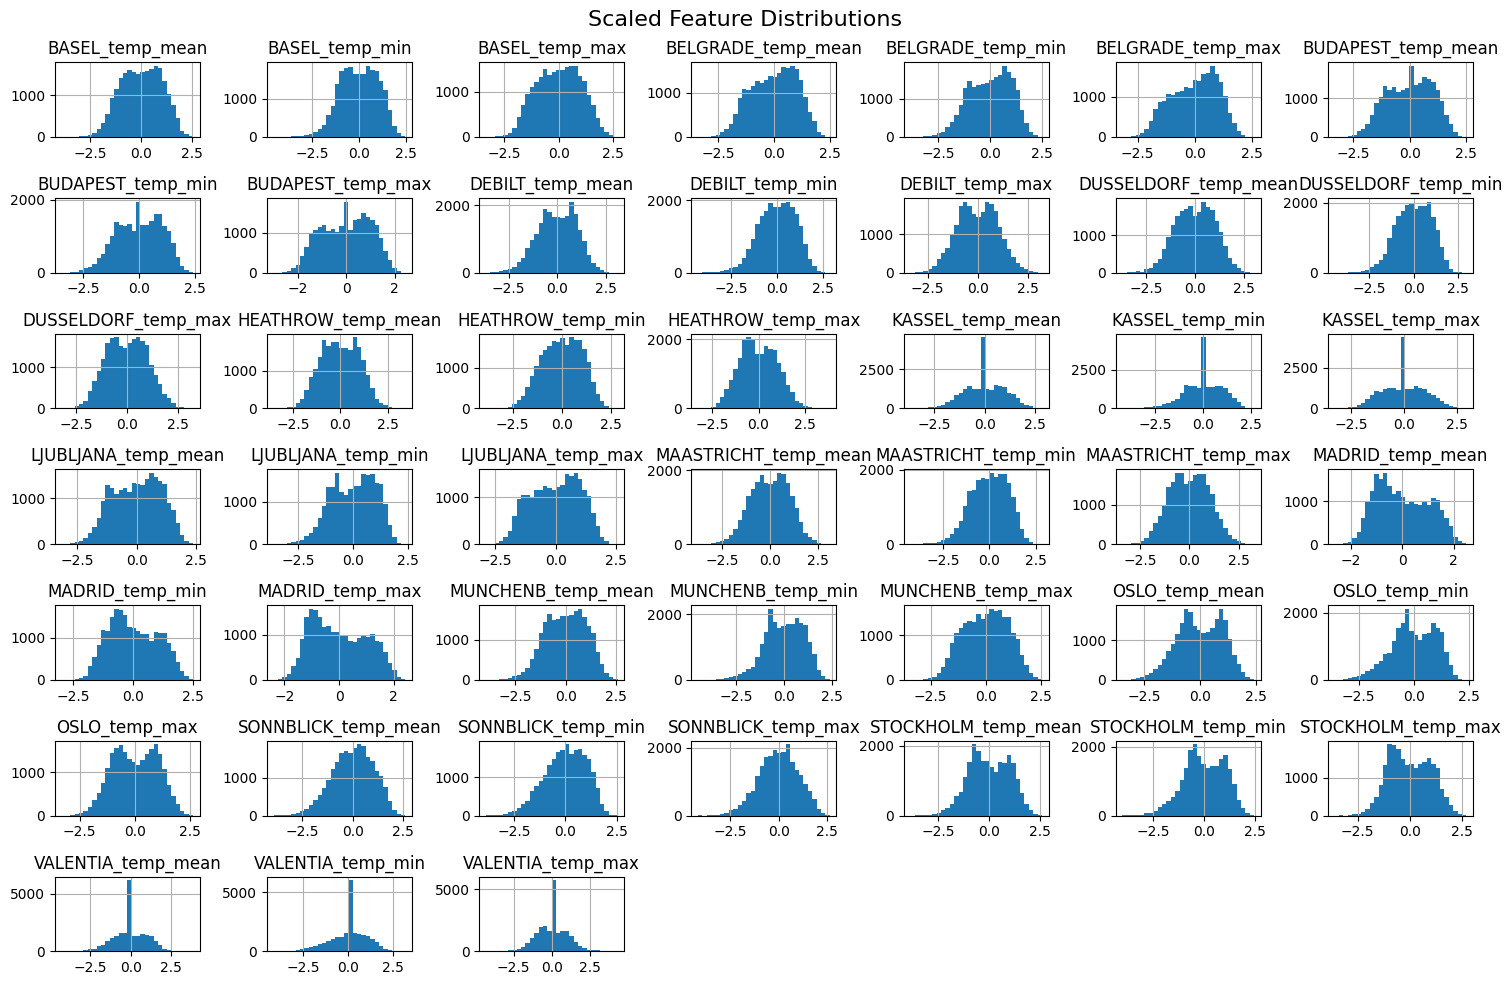

In [18]:
X.hist(figsize=(15, 10), bins=30)
plt.suptitle("Scaled Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()


#### Notable Outliers
KASSEL and VALENTIA: The distributions for these locations (especially KASSEL_temp_mean, KASSEL_temp_min, KASSEL_temp_max, and the VALENTIA features) show sharp spikes or heavy tails, likely due to one or a few extreme outlier days

# ANN (from scratch)

In [19]:
### Split into train/test first (on unscaled X1)

from sklearn.model_selection import train_test_split

X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)


In [20]:
### Scale after split, using only training data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)


In [22]:
### Run no.1 - Baseline Model

from sklearn.neural_network import MLPClassifier

mlp1 = MLPClassifier(hidden_layer_sizes=(50,), max_iter=300, random_state=42)

mlp1.fit(X1_train_scaled, y_train)
print("Train accuracy:", mlp1.score(X1_train_scaled, y_train))
print("Test accuracy:", mlp1.score(X1_test_scaled, y_test))


Train accuracy: 0.5406862745098039
Test accuracy: 0.5337690631808278


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


### Observation
The numbers are close, meaning the model is probably not overfitting, even if the performance isn't stellar yet.
But the low 50% accuracy does suggest the model is struggling with the task—just barely better than random guessing!

In [23]:
### Run no.2 - Deeper Network, Longer Training

mlp2 = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

mlp2.fit(X1_train_scaled, y_train)
print("Train accuracy:", mlp2.score(X1_train_scaled, y_train))
print("Test accuracy:", mlp2.score(X1_test_scaled, y_test))

Train accuracy: 0.5723311546840959
Test accuracy: 0.5104575163398692


In [24]:
### Run no.3 - High Complexity

mlp3 = MLPClassifier(hidden_layer_sizes=(100, 50, 20), max_iter=1000, tol=1e-5, random_state=42)

mlp3.fit(X1_train_scaled, y_train)
print("Train accuracy:", mlp3.score(X1_train_scaled, y_train))
print("Test accuracy:", mlp3.score(X1_test_scaled, y_test))

Train accuracy: 0.5797930283224401
Test accuracy: 0.5217864923747276


| Layers      | Max Iter | Tol  | Train Acc | Test Acc |
| ----------- | -------- | ---- | --------- | -------- |
| `(50,)`     | 300      | 1e-4 | 0.54      | 0.53     |
| `(100, 50)` | 1000     | 1e-4 | 0.57      | 0.51     |
| `(100, 50, 20)` | 1000     | 1e-5 | 0.58        | 0.52       |


### Observations:
Our baseline model achieved an accuracy only slightly above random guessing. To encourage the network to learn more complex patterns, we increased both the number of layers and the number of nodes in the second run. We also raised the maximum iterations to allow the model more time to converge. As expected, training accuracy improved, but test accuracy declined—indicating the model was learning more specific details from the training data at the expense of generalization.

The third and most complex model included an additional layer and a tighter convergence tolerance. While this produced a marginal gain in training accuracy and a slight recovery in test accuracy, performance still didn’t surpass the baseline. Across all three models, we observed a consistent rise in training accuracy with increasing complexity—this aligns with expectations, as deeper networks are more capable of fitting data. However, the persistent failure of test accuracy to improve suggests overfitting, limitations in the feature set, or excessive noise in the dataset.

(ChatGPT suggestion: To improve performance, future iterations could explore regularization techniques, feature engineering, or dimensionality reduction to reduce noise and help the network focus on more meaningful patterns.)

## 4. Confusion Matrices

In [28]:
list(y.columns)

['BASEL_pleasant_weather',
 'BELGRADE_pleasant_weather',
 'BUDAPEST_pleasant_weather',
 'DEBILT_pleasant_weather',
 'DUSSELDORF_pleasant_weather',
 'HEATHROW_pleasant_weather',
 'KASSEL_pleasant_weather',
 'LJUBLJANA_pleasant_weather',
 'MAASTRICHT_pleasant_weather',
 'MADRID_pleasant_weather',
 'MUNCHENB_pleasant_weather',
 'OSLO_pleasant_weather',
 'SONNBLICK_pleasant_weather',
 'STOCKHOLM_pleasant_weather',
 'VALENTIA_pleasant_weather']

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


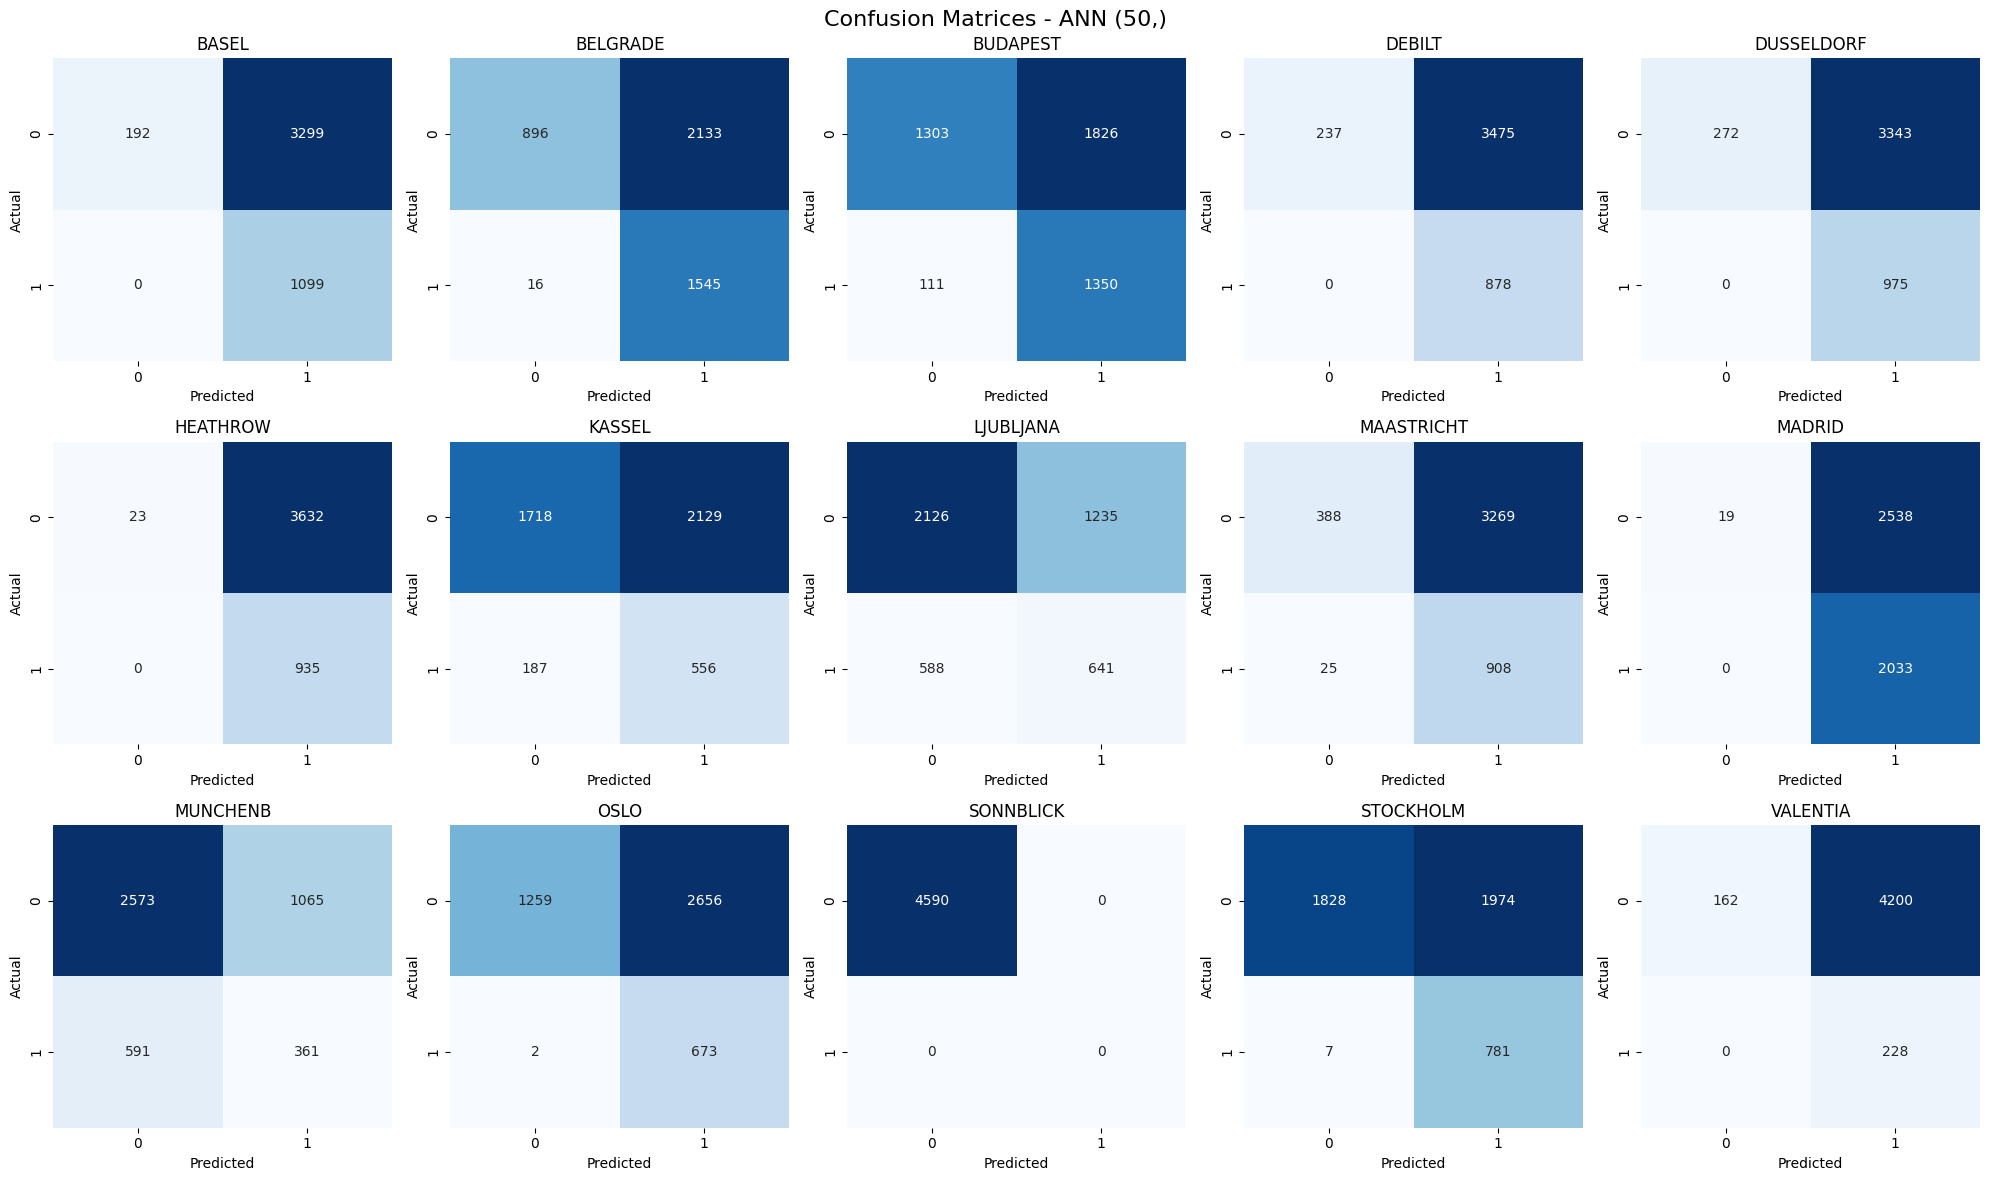

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


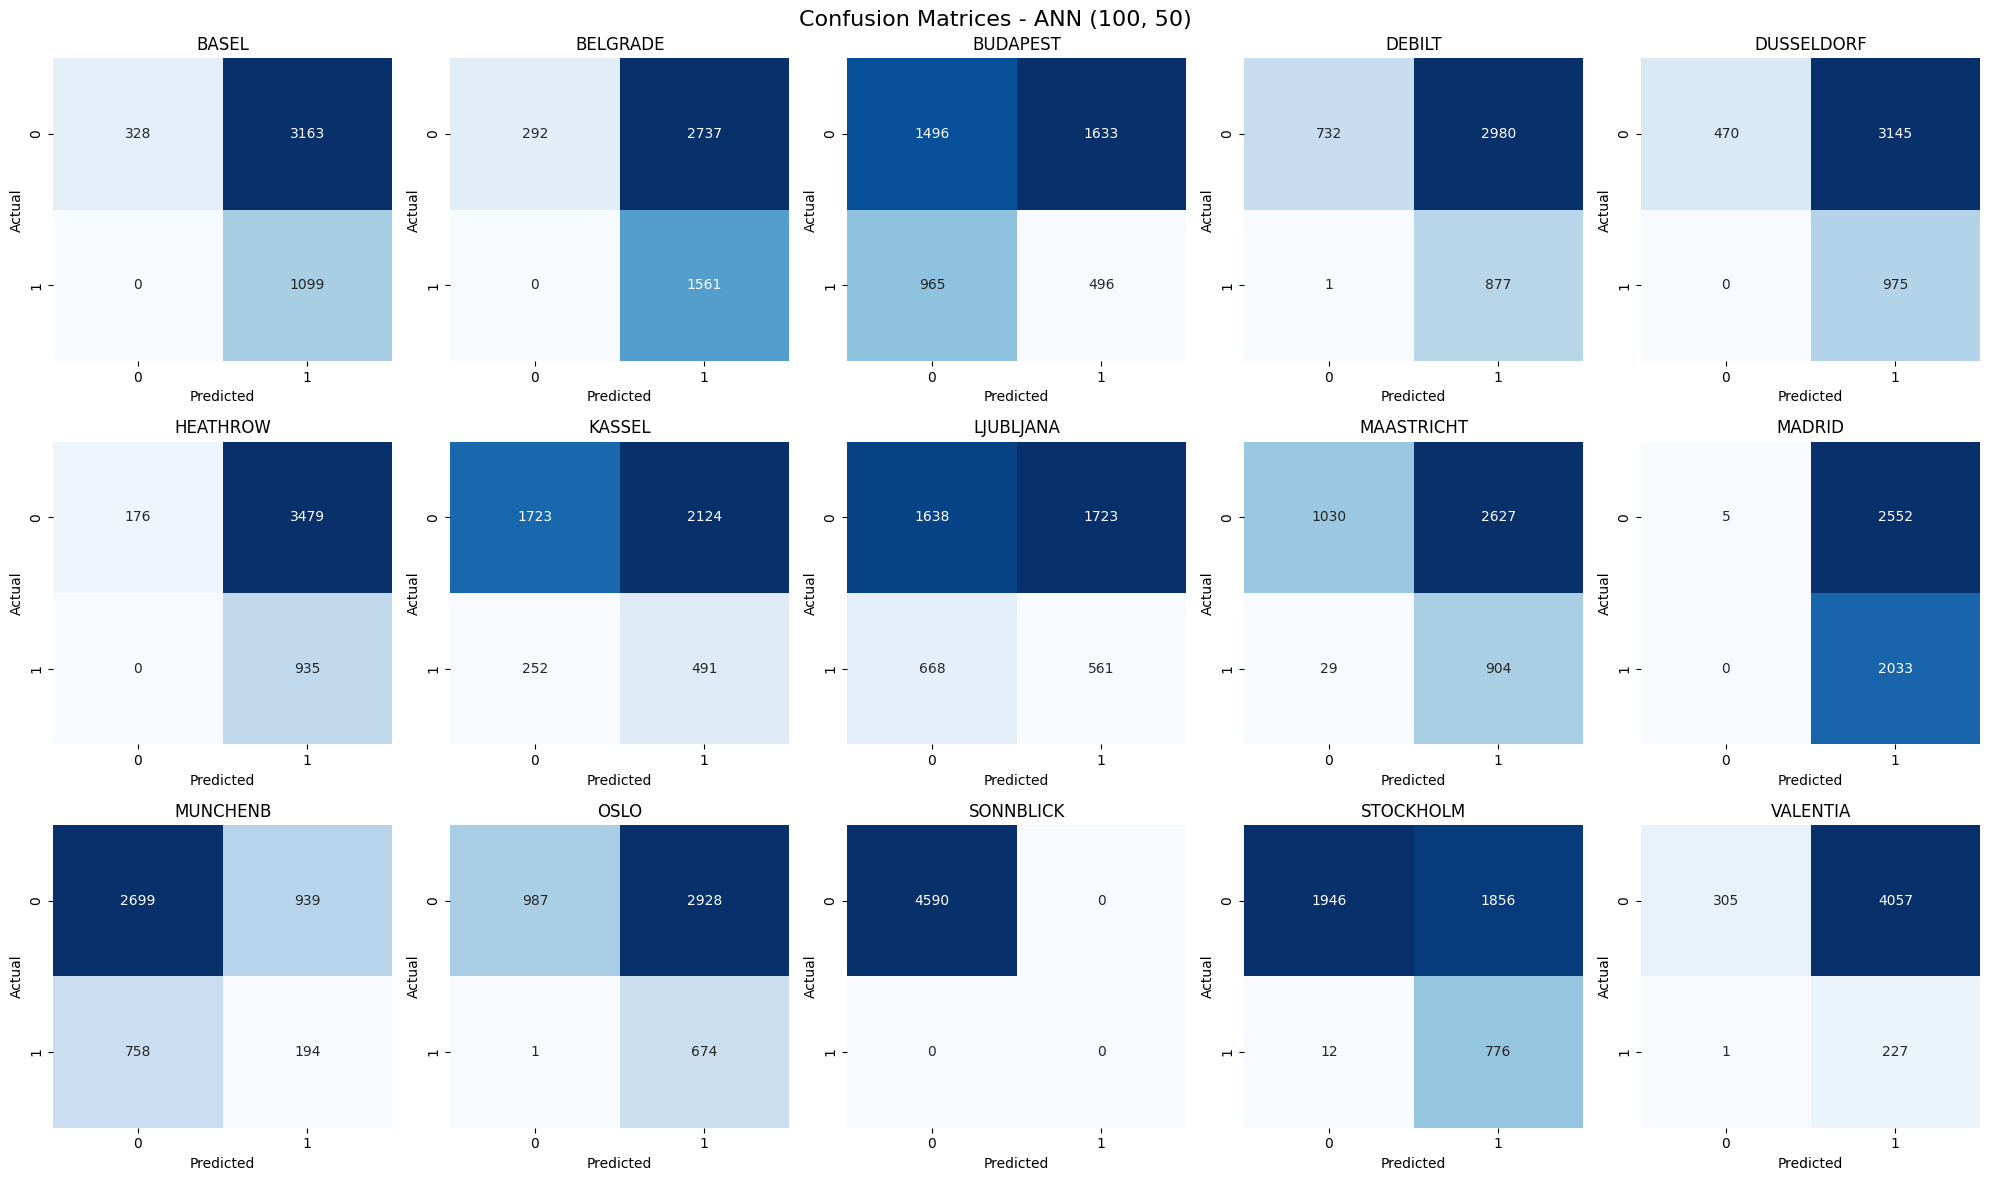

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


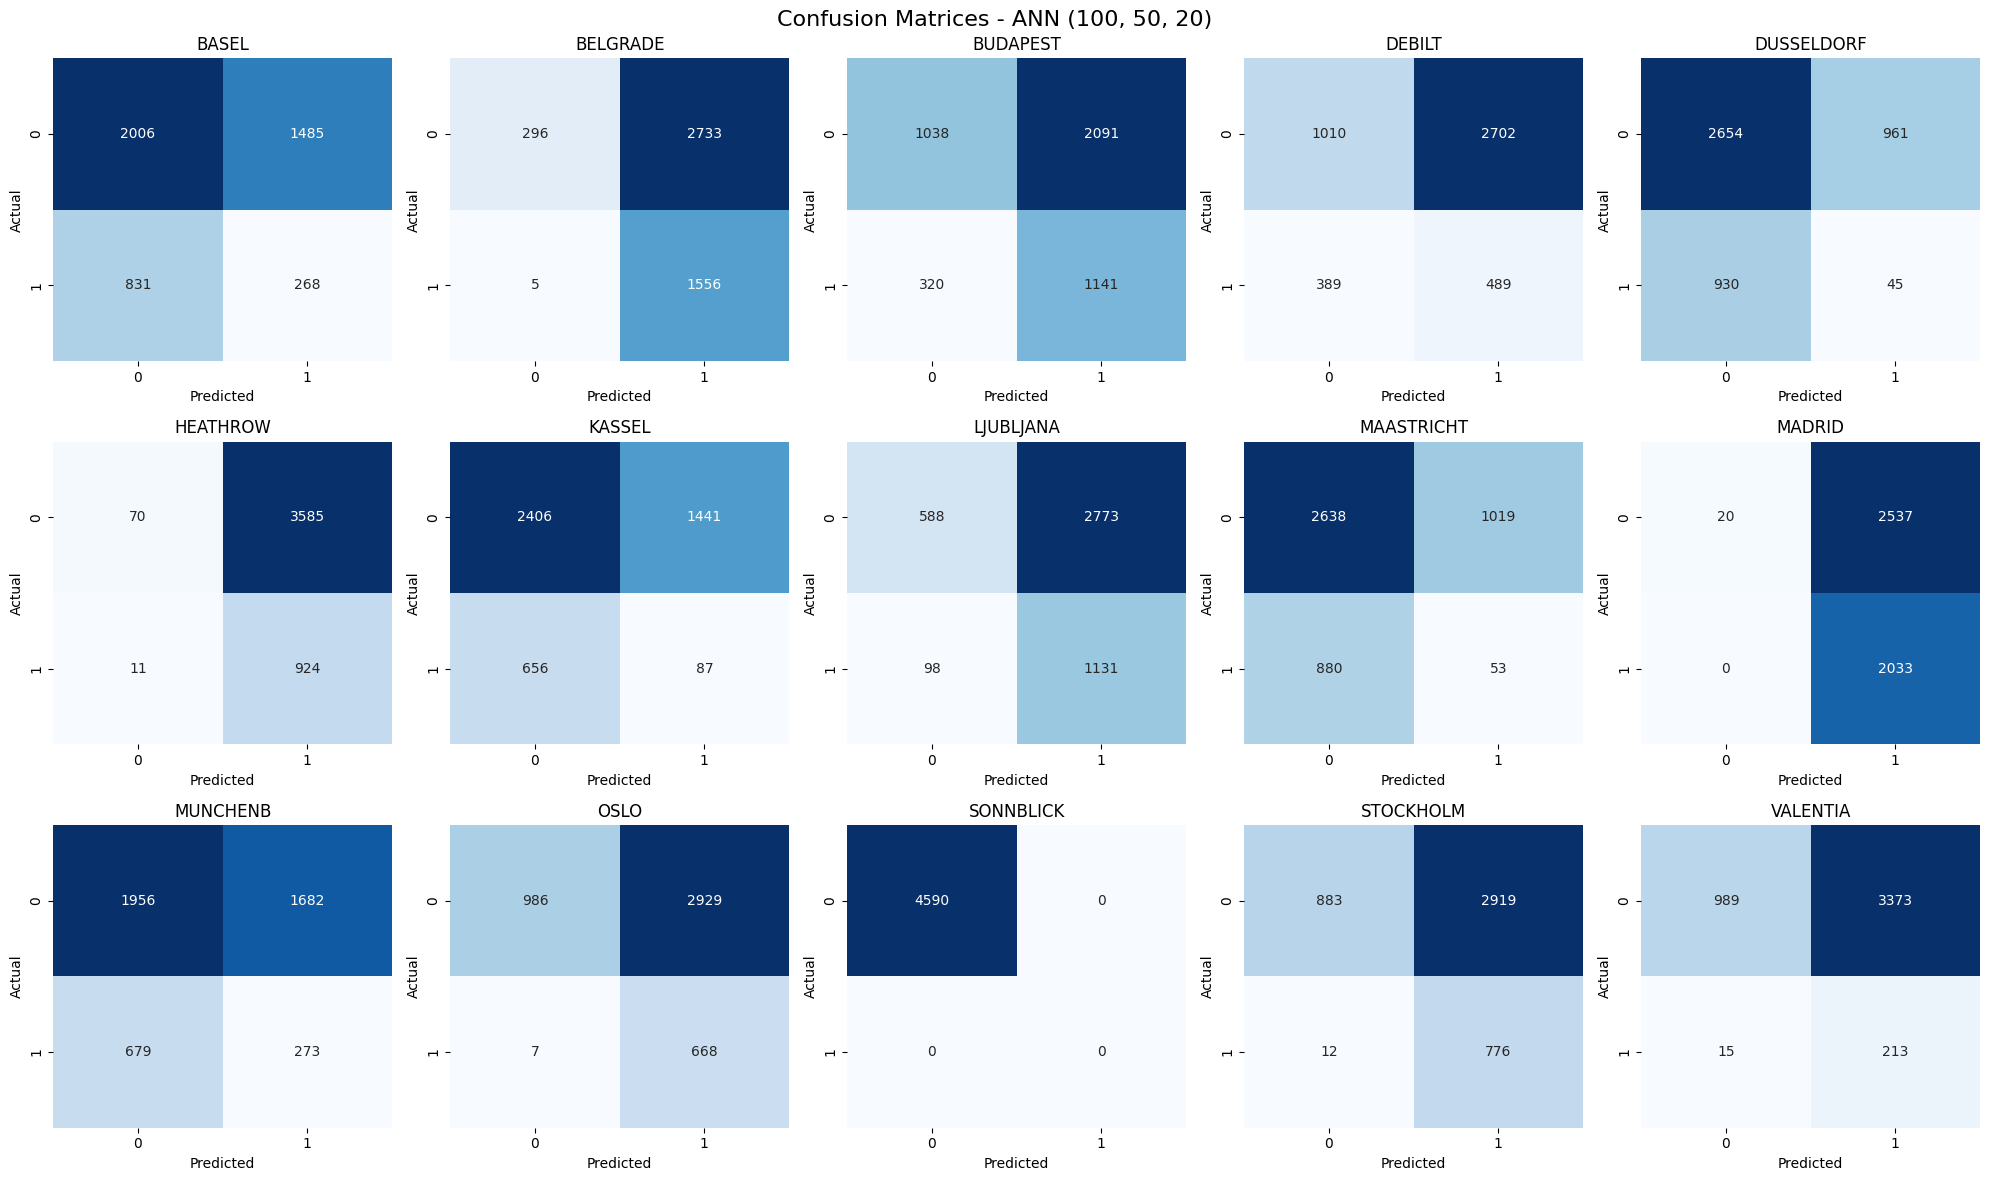

In [29]:
station_names = [
    'BASEL', 'BELGRADE', 'BUDAPEST', 'DEBILT', 'DUSSELDORF', 'HEATHROW',
    'KASSEL', 'LJUBLJANA', 'MAASTRICHT', 'MADRID', 'MUNCHENB', 'OSLO',
    'SONNBLICK', 'STOCKHOLM', 'VALENTIA'
]

def plot_multi_confusion_matrix(y_true, y_pred, model_name, station_names=None):
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    num_stations = len(mcm)

    fig, axes = plt.subplots(3, 5, figsize=(20, 12))
    fig.suptitle(f"Confusion Matrices - {model_name}", fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i >= num_stations:
            ax.axis('off')
            continue
        cm = mcm[i]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        # Use station_names list for titles, else default to Station i
        title = station_names[i] if station_names else f"Station {i}"
        ax.set_title(title, fontsize=12)
    plt.tight_layout()
    plt.show()

# Then call it with the station names:
y_pred_1 = mlp1.predict(X1_test)
plot_multi_confusion_matrix(y_test, y_pred_1, model_name="ANN (50,)", station_names=station_names)

y_pred_2 = mlp2.predict(X1_test)
plot_multi_confusion_matrix(y_test, y_pred_2, model_name="ANN (100, 50)", station_names=station_names)

y_pred_3 = mlp3.predict(X1_test)
plot_multi_confusion_matrix(y_test, y_pred_3, model_name="ANN (100, 50, 20)", station_names=station_names)
